In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch
from sklearn.metrics import classification_report

## Build synthetic data
Here, we build a simple synthetic data scenario by modeling two normally distributed features (A and B), and then a target class C that is also normally distributed and directly conditioned on A and B via a simple linear function. We add small noise vectors to all our values.

### Modifying disparity
Furthermore, we can adjust the disparity between a group of "male" individuals and a group of "female" individuals. 

By moving the "center=(1.0,2.0)" of the two feature distributions, we can increase or decrease the disparity along both feature axes (A,B), which will have a downstream effect on C.

#### Note
The default disparity is imbalanced, across a global mean of 0. Male dataframe has the positive mean, and female dataframe has the negative one. By Moving the two "centerings" closer, we can decrease the disparity. If the centerings are the same, then there is no disparity. Extremely different centerings, meanwhile, should have no class overlap.

In [61]:
def build_group(df, n=1000, center=(1.0,2.0)):
    for _ in range(n):
        noise1 = pyro.sample('N', dist.Normal(torch.tensor(0.0),0.2))
        noise2 = pyro.sample('N', dist.Normal(torch.tensor(0.0),0.2))
        noise3 = pyro.sample('N', dist.Normal(torch.tensor(0.0),0.2))
        A = pyro.sample('A', dist.Normal(torch.tensor(center[0]), 1))
        B = pyro.sample('B', dist.Normal(torch.tensor(center[1]), 1))
        C = pyro.sample('C', dist.Normal(A+B, 2))
        A = A + noise1
        B = B + noise2
        C = C + noise3
        df = df.append({
            'A': A.item(),
            'B': B.item(),
            'C': C.item(),
        }, ignore_index=True)
    return df

# NOTE: see "center" instructions above to modify the disparity
df_synth_male = pd.DataFrame({}, columns=['A','B','C'])
df_synth_male = build_group(df_synth_male, center=(1.0,2.0))
df_synth_female = pd.DataFrame({}, columns=['A','B','C'])
df_synth_female = build_group(df_synth_female, center=(-1.0,-2.0))
df_synth_male['M'] = 1
df_synth_female['M'] = 0
df_synth_male['F'] = 0
df_synth_female['F'] = 1
df_synth = pd.concat([df_synth_female,df_synth_male], ignore_index=True)
df_synth = df_synth.sample(frac=1)
df_synth['class'] = 0
df_synth.loc[(df_synth["C"] > 0), "class"] = 1
df_synth

,A,B,C,M,F,class
811,-1.768914,-4.098336,-3.451186,0,1,0
1833,-0.582706,1.727181,-1.297873,1,0,0
1192,0.540980,2.715096,3.000985,1,0,1
569,0.160512,-1.628792,-4.508429,0,1,0
1605,1.126236,1.571586,1.413476,1,0,1
...,...,...,...,...,...,...
1341,0.691892,1.616095,7.326405,1,0,1
1933,1.491788,3.034701,4.139513,1,0,1
1484,0.833627,0.243011,-0.232925,1,0,0
1452,0.476253,1.689523,-0.243538,1,0,0


Here, we see that the inherent classification task (thresholding at 0) gives us a sense of the disparity. ~10% of each group is within the other groups distribution.

In [62]:
features = ['A','B']
# features.remove('F')
target = 'class'
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_synth[features], df_synth[target], test_size=0.2, random_state=42)
model = LogisticRegression().fit(X_train, y_train)
model.score(X_test, y_test)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# pd.DataFrame({'pred': y_pred, 'test': y_test})

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       202
           1       0.90      0.91      0.90       198

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



We can see that when plotting along the binary "class" variable, and the tail overlap along "C".

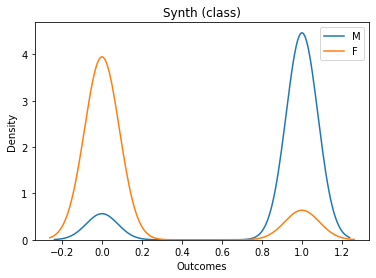

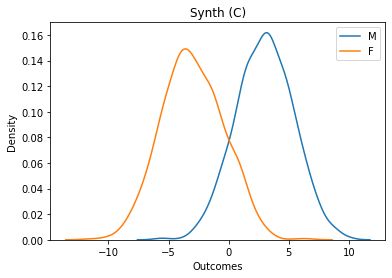

In [63]:
groups = ['M', 'F']
pred_type = ['class', 'C']
for pred in pred_type:
    fig, ax = plt.subplots()
    for j in range(len(groups)):
        group = groups[j]
        sns.kdeplot(df_synth[df_synth[group] == 1][pred], ax=ax,label=group)
    plt.title('Synth ('+str(pred)+')')
    plt.xlabel('Outcomes')
    plt.legend()

It is also useful to visualize the group imbalances along the features, "A" and "B".

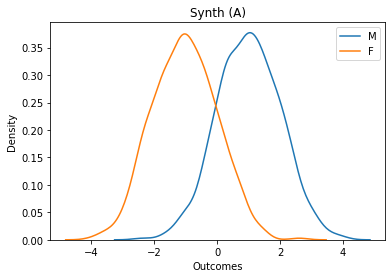

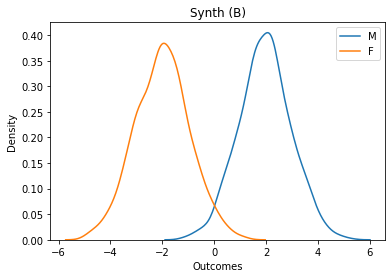

In [64]:
groups = ['M', 'F']
pred_type = ['A', 'B']
for pred in pred_type:
    fig, ax = plt.subplots()
    for j in range(len(groups)):
        group = groups[j]
        sns.kdeplot(df_synth[df_synth[group] == 1][pred], ax=ax,label=group)
    plt.title('Synth ('+str(pred)+')')
    plt.xlabel('Outcomes')
    plt.legend()